# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-keras-model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

  679936/11490434 [>.............................] - ETA: 0s

 1941504/11490434 [====>.........................] - ETA: 0s

 3973120/11490434 [=========>....................] - ETA: 0s

 5038080/11490434 [============>.................] - ETA: 0s

 7168000/11490434 [=================>............] - ETA: 0s

10887168/11490434 [===========================>..] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 1:01:59 - loss: 0.6944

  15/1875 [..............................] - ETA: 6s - loss: 0.6226     

  28/1875 [..............................] - ETA: 6s - loss: 0.5552

  40/1875 [..............................] - ETA: 7s - loss: 0.5124

  55/1875 [..............................] - ETA: 6s - loss: 0.4754

  68/1875 [>.............................] - ETA: 6s - loss: 0.4520

  84/1875 [>.............................] - ETA: 6s - loss: 0.4300

  95/1875 [>.............................] - ETA: 6s - loss: 0.4179

 111/1875 [>.............................] - ETA: 6s - loss: 0.4031

 120/1875 [>.............................] - ETA: 6s - loss: 0.3959

 128/1875 [=>............................] - ETA: 7s - loss: 0.3901

 136/1875 [=>............................] - ETA: 7s - loss: 0.3847

 149/1875 [=>............................] - ETA: 7s - loss: 0.3768

 158/1875 [=>............................] - ETA: 7s - loss: 0.3717

 171/1875 [=>............................] - ETA: 7s - loss: 0.3650

 183/1875 [=>............................] - ETA: 7s - loss: 0.3594

 188/1875 [==>...........................] - ETA: 7s - loss: 0.3572

 191/1875 [==>...........................] - ETA: 8s - loss: 0.3559

 202/1875 [==>...........................] - ETA: 8s - loss: 0.3513

 213/1875 [==>...........................] - ETA: 8s - loss: 0.3470

 225/1875 [==>...........................] - ETA: 7s - loss: 0.3426

 236/1875 [==>...........................] - ETA: 7s - loss: 0.3388

 245/1875 [==>...........................] - ETA: 7s - loss: 0.3359

 262/1875 [===>..........................] - ETA: 7s - loss: 0.3306

 273/1875 [===>..........................] - ETA: 7s - loss: 0.3274

 286/1875 [===>..........................] - ETA: 7s - loss: 0.3238

 301/1875 [===>..........................] - ETA: 7s - loss: 0.3199

 313/1875 [====>.........................] - ETA: 7s - loss: 0.3169

 326/1875 [====>.........................] - ETA: 7s - loss: 0.3138

 338/1875 [====>.........................] - ETA: 7s - loss: 0.3111

 350/1875 [====>.........................] - ETA: 7s - loss: 0.3085

 363/1875 [====>.........................] - ETA: 7s - loss: 0.3058

 376/1875 [=====>........................] - ETA: 6s - loss: 0.3032

 388/1875 [=====>........................] - ETA: 6s - loss: 0.3009

 396/1875 [=====>........................] - ETA: 6s - loss: 0.2994

 410/1875 [=====>........................] - ETA: 6s - loss: 0.2969

 423/1875 [=====>........................] - ETA: 6s - loss: 0.2946

 434/1875 [=====>........................] - ETA: 6s - loss: 0.2928

 448/1875 [======>.......................] - ETA: 6s - loss: 0.2905

 463/1875 [======>.......................] - ETA: 6s - loss: 0.2882

 473/1875 [======>.......................] - ETA: 6s - loss: 0.2866

 483/1875 [======>.......................] - ETA: 6s - loss: 0.2852

 496/1875 [======>.......................] - ETA: 6s - loss: 0.2833

 509/1875 [=======>......................] - ETA: 6s - loss: 0.2815

 518/1875 [=======>......................] - ETA: 6s - loss: 0.2803

 534/1875 [=======>......................] - ETA: 6s - loss: 0.2782

 547/1875 [=======>......................] - ETA: 5s - loss: 0.2765

 558/1875 [=======>......................] - ETA: 5s - loss: 0.2752

 562/1875 [=======>......................] - ETA: 5s - loss: 0.2747

 575/1875 [========>.....................] - ETA: 5s - loss: 0.2731

 589/1875 [========>.....................] - ETA: 5s - loss: 0.2715

 598/1875 [========>.....................] - ETA: 5s - loss: 0.2705

 614/1875 [========>.....................] - ETA: 5s - loss: 0.2687

 627/1875 [=========>....................] - ETA: 5s - loss: 0.2673

 634/1875 [=========>....................] - ETA: 5s - loss: 0.2666

 645/1875 [=========>....................] - ETA: 5s - loss: 0.2654

 658/1875 [=========>....................] - ETA: 5s - loss: 0.2641

 668/1875 [=========>....................] - ETA: 5s - loss: 0.2631

 682/1875 [=========>....................] - ETA: 5s - loss: 0.2617

 693/1875 [==========>...................] - ETA: 5s - loss: 0.2607

 706/1875 [==========>...................] - ETA: 5s - loss: 0.2595

 722/1875 [==========>...................] - ETA: 5s - loss: 0.2580

 737/1875 [==========>...................] - ETA: 5s - loss: 0.2567

 750/1875 [===========>..................] - ETA: 5s - loss: 0.2556

 763/1875 [===========>..................] - ETA: 4s - loss: 0.2545

 777/1875 [===========>..................] - ETA: 4s - loss: 0.2533

 790/1875 [===========>..................] - ETA: 4s - loss: 0.2522

 804/1875 [===========>..................] - ETA: 4s - loss: 0.2511

 810/1875 [===========>..................] - ETA: 4s - loss: 0.2506

 825/1875 [============>.................] - ETA: 4s - loss: 0.2495

 833/1875 [============>.................] - ETA: 4s - loss: 0.2489

 840/1875 [============>.................] - ETA: 4s - loss: 0.2483

 856/1875 [============>.................] - ETA: 4s - loss: 0.2472

 869/1875 [============>.................] - ETA: 4s - loss: 0.2462

 880/1875 [=============>................] - ETA: 4s - loss: 0.2454

 894/1875 [=============>................] - ETA: 4s - loss: 0.2444

 912/1875 [=============>................] - ETA: 4s - loss: 0.2432

 925/1875 [=============>................] - ETA: 4s - loss: 0.2423

 941/1875 [==============>...............] - ETA: 4s - loss: 0.2413

 958/1875 [==============>...............] - ETA: 4s - loss: 0.2402

 972/1875 [==============>...............] - ETA: 3s - loss: 0.2393

 987/1875 [==============>...............] - ETA: 3s - loss: 0.2383

1000/1875 [===============>..............] - ETA: 3s - loss: 0.2376

1015/1875 [===============>..............] - ETA: 3s - loss: 0.2367

1028/1875 [===============>..............] - ETA: 3s - loss: 0.2359

1045/1875 [===============>..............] - ETA: 3s - loss: 0.2349

1057/1875 [===============>..............] - ETA: 3s - loss: 0.2342

1074/1875 [================>.............] - ETA: 3s - loss: 0.2332

1088/1875 [================>.............] - ETA: 3s - loss: 0.2325

1103/1875 [================>.............] - ETA: 3s - loss: 0.2317

1117/1875 [================>.............] - ETA: 3s - loss: 0.2309

1130/1875 [=================>............] - ETA: 3s - loss: 0.2302

1144/1875 [=================>............] - ETA: 3s - loss: 0.2295

1161/1875 [=================>............] - ETA: 3s - loss: 0.2286

1173/1875 [=================>............] - ETA: 2s - loss: 0.2280

1189/1875 [==================>...........] - ETA: 2s - loss: 0.2272

1206/1875 [==================>...........] - ETA: 2s - loss: 0.2264

1216/1875 [==================>...........] - ETA: 2s - loss: 0.2259

1230/1875 [==================>...........] - ETA: 2s - loss: 0.2253

1238/1875 [==================>...........] - ETA: 2s - loss: 0.2249

1256/1875 [===================>..........] - ETA: 2s - loss: 0.2240

1268/1875 [===================>..........] - ETA: 2s - loss: 0.2235

1281/1875 [===================>..........] - ETA: 2s - loss: 0.2229

1298/1875 [===================>..........] - ETA: 2s - loss: 0.2221

1316/1875 [====================>.........] - ETA: 2s - loss: 0.2214

1331/1875 [====================>.........] - ETA: 2s - loss: 0.2207

1344/1875 [====================>.........] - ETA: 2s - loss: 0.2202

1356/1875 [====================>.........] - ETA: 2s - loss: 0.2196

1369/1875 [====================>.........] - ETA: 2s - loss: 0.2191

1383/1875 [=====================>........] - ETA: 2s - loss: 0.2185

1399/1875 [=====================>........] - ETA: 1s - loss: 0.2179

1415/1875 [=====================>........] - ETA: 1s - loss: 0.2172

1431/1875 [=====================>........] - ETA: 1s - loss: 0.2166

1442/1875 [======================>.......] - ETA: 1s - loss: 0.2162

1459/1875 [======================>.......] - ETA: 1s - loss: 0.2155

1471/1875 [======================>.......] - ETA: 1s - loss: 0.2151

1483/1875 [======================>.......] - ETA: 1s - loss: 0.2146

1495/1875 [======================>.......] - ETA: 1s - loss: 0.2142

1503/1875 [=======================>......] - ETA: 1s - loss: 0.2139

1517/1875 [=======================>......] - ETA: 1s - loss: 0.2134

1531/1875 [=======================>......] - ETA: 1s - loss: 0.2129

1545/1875 [=======================>......] - ETA: 1s - loss: 0.2124

1557/1875 [=======================>......] - ETA: 1s - loss: 0.2119

1572/1875 [========================>.....] - ETA: 1s - loss: 0.2114

1587/1875 [========================>.....] - ETA: 1s - loss: 0.2109

1597/1875 [========================>.....] - ETA: 1s - loss: 0.2105

1609/1875 [========================>.....] - ETA: 1s - loss: 0.2101

1621/1875 [========================>.....] - ETA: 1s - loss: 0.2097

1630/1875 [=========================>....] - ETA: 1s - loss: 0.2094

1643/1875 [=========================>....] - ETA: 0s - loss: 0.2090

1656/1875 [=========================>....] - ETA: 0s - loss: 0.2086

1666/1875 [=========================>....] - ETA: 0s - loss: 0.2082

1675/1875 [=========================>....] - ETA: 0s - loss: 0.2079

1685/1875 [=========================>....] - ETA: 0s - loss: 0.2076

1697/1875 [==========================>...] - ETA: 0s - loss: 0.2072

1706/1875 [==========================>...] - ETA: 0s - loss: 0.2070

1718/1875 [==========================>...] - ETA: 0s - loss: 0.2066

1727/1875 [==========================>...] - ETA: 0s - loss: 0.2063

1742/1875 [==========================>...] - ETA: 0s - loss: 0.2058

1755/1875 [===========================>..] - ETA: 0s - loss: 0.2054

1767/1875 [===========================>..] - ETA: 0s - loss: 0.2051

1778/1875 [===========================>..] - ETA: 0s - loss: 0.2048

1788/1875 [===========================>..] - ETA: 0s - loss: 0.2045

1797/1875 [===========================>..] - ETA: 0s - loss: 0.2042

1809/1875 [===========================>..] - ETA: 0s - loss: 0.2038

1822/1875 [============================>.] - ETA: 0s - loss: 0.2035

1836/1875 [============================>.] - ETA: 0s - loss: 0.2031

1846/1875 [============================>.] - ETA: 0s - loss: 0.2028

1861/1875 [============================>.] - ETA: 0s - loss: 0.2023

1874/1875 [============================>.] - ETA: 0s - loss: 0.2020

1875/1875 [==============================] - 10s 4ms/step - loss: 0.2019


Epoch 2/5
   1/1875 [..............................] - ETA: 12s - loss: 0.1124

  11/1875 [..............................] - ETA: 11s - loss: 0.1104

  18/1875 [..............................] - ETA: 12s - loss: 0.1095

  31/1875 [..............................] - ETA: 10s - loss: 0.1092

  47/1875 [..............................] - ETA: 8s - loss: 0.1091 

  57/1875 [..............................] - ETA: 8s - loss: 0.1090

  65/1875 [>.............................] - ETA: 9s - loss: 0.1090

  71/1875 [>.............................] - ETA: 9s - loss: 0.1089

  84/1875 [>.............................] - ETA: 9s - loss: 0.1089

  96/1875 [>.............................] - ETA: 9s - loss: 0.1088

 108/1875 [>.............................] - ETA: 8s - loss: 0.1088

 117/1875 [>.............................] - ETA: 9s - loss: 0.1087

 130/1875 [=>............................] - ETA: 8s - loss: 0.1086

 142/1875 [=>............................] - ETA: 8s - loss: 0.1086

 154/1875 [=>............................] - ETA: 8s - loss: 0.1085

 162/1875 [=>............................] - ETA: 8s - loss: 0.1085

 170/1875 [=>............................] - ETA: 8s - loss: 0.1085

 181/1875 [=>............................] - ETA: 8s - loss: 0.1085

 194/1875 [==>...........................] - ETA: 8s - loss: 0.1084

 206/1875 [==>...........................] - ETA: 8s - loss: 0.1084

 219/1875 [==>...........................] - ETA: 8s - loss: 0.1084

 230/1875 [==>...........................] - ETA: 8s - loss: 0.1084

 247/1875 [==>...........................] - ETA: 7s - loss: 0.1084

 255/1875 [===>..........................] - ETA: 7s - loss: 0.1084

 267/1875 [===>..........................] - ETA: 7s - loss: 0.1084

 275/1875 [===>..........................] - ETA: 7s - loss: 0.1083

 285/1875 [===>..........................] - ETA: 7s - loss: 0.1083

 297/1875 [===>..........................] - ETA: 7s - loss: 0.1083

 312/1875 [===>..........................] - ETA: 7s - loss: 0.1083

 324/1875 [====>.........................] - ETA: 7s - loss: 0.1083

 341/1875 [====>.........................] - ETA: 7s - loss: 0.1083

 358/1875 [====>.........................] - ETA: 7s - loss: 0.1083

 368/1875 [====>.........................] - ETA: 7s - loss: 0.1083

 381/1875 [=====>........................] - ETA: 6s - loss: 0.1083

 389/1875 [=====>........................] - ETA: 6s - loss: 0.1082

 407/1875 [=====>........................] - ETA: 6s - loss: 0.1082

 421/1875 [=====>........................] - ETA: 6s - loss: 0.1082

 434/1875 [=====>........................] - ETA: 6s - loss: 0.1082

 450/1875 [======>.......................] - ETA: 6s - loss: 0.1082

 460/1875 [======>.......................] - ETA: 6s - loss: 0.1081

 470/1875 [======>.......................] - ETA: 6s - loss: 0.1081

 486/1875 [======>.......................] - ETA: 6s - loss: 0.1081

 496/1875 [======>.......................] - ETA: 6s - loss: 0.1081

 510/1875 [=======>......................] - ETA: 6s - loss: 0.1081

 523/1875 [=======>......................] - ETA: 6s - loss: 0.1080

 534/1875 [=======>......................] - ETA: 6s - loss: 0.1080

 548/1875 [=======>......................] - ETA: 5s - loss: 0.1080

 556/1875 [=======>......................] - ETA: 5s - loss: 0.1080

 568/1875 [========>.....................] - ETA: 5s - loss: 0.1080

 585/1875 [========>.....................] - ETA: 5s - loss: 0.1079

 593/1875 [========>.....................] - ETA: 5s - loss: 0.1079

 604/1875 [========>.....................] - ETA: 5s - loss: 0.1079

 611/1875 [========>.....................] - ETA: 5s - loss: 0.1079

 617/1875 [========>.....................] - ETA: 5s - loss: 0.1079

 625/1875 [=========>....................] - ETA: 5s - loss: 0.1079

 634/1875 [=========>....................] - ETA: 5s - loss: 0.1078

 649/1875 [=========>....................] - ETA: 5s - loss: 0.1078

 660/1875 [=========>....................] - ETA: 5s - loss: 0.1078

 674/1875 [=========>....................] - ETA: 5s - loss: 0.1078

 685/1875 [=========>....................] - ETA: 5s - loss: 0.1077

 696/1875 [==========>...................] - ETA: 5s - loss: 0.1077

 706/1875 [==========>...................] - ETA: 5s - loss: 0.1077

 714/1875 [==========>...................] - ETA: 5s - loss: 0.1077

 724/1875 [==========>...................] - ETA: 5s - loss: 0.1077

 738/1875 [==========>...................] - ETA: 5s - loss: 0.1076

 752/1875 [===========>..................] - ETA: 5s - loss: 0.1076

 761/1875 [===========>..................] - ETA: 5s - loss: 0.1076

 772/1875 [===========>..................] - ETA: 5s - loss: 0.1076

 782/1875 [===========>..................] - ETA: 5s - loss: 0.1075

 796/1875 [===========>..................] - ETA: 4s - loss: 0.1075

 806/1875 [===========>..................] - ETA: 4s - loss: 0.1075

 819/1875 [============>.................] - ETA: 4s - loss: 0.1075

 832/1875 [============>.................] - ETA: 4s - loss: 0.1075

 847/1875 [============>.................] - ETA: 4s - loss: 0.1074

 863/1875 [============>.................] - ETA: 4s - loss: 0.1074

 877/1875 [=============>................] - ETA: 4s - loss: 0.1074

 891/1875 [=============>................] - ETA: 4s - loss: 0.1073

 905/1875 [=============>................] - ETA: 4s - loss: 0.1073

 921/1875 [=============>................] - ETA: 4s - loss: 0.1073

 935/1875 [=============>................] - ETA: 4s - loss: 0.1073

 950/1875 [==============>...............] - ETA: 4s - loss: 0.1072

 963/1875 [==============>...............] - ETA: 4s - loss: 0.1072

 977/1875 [==============>...............] - ETA: 4s - loss: 0.1072

 991/1875 [==============>...............] - ETA: 3s - loss: 0.1072

1002/1875 [===============>..............] - ETA: 3s - loss: 0.1071

1021/1875 [===============>..............] - ETA: 3s - loss: 0.1071

1033/1875 [===============>..............] - ETA: 3s - loss: 0.1071

1042/1875 [===============>..............] - ETA: 3s - loss: 0.1071

1061/1875 [===============>..............] - ETA: 3s - loss: 0.1070

1074/1875 [================>.............] - ETA: 3s - loss: 0.1070

1086/1875 [================>.............] - ETA: 3s - loss: 0.1070

1100/1875 [================>.............] - ETA: 3s - loss: 0.1070

1119/1875 [================>.............] - ETA: 3s - loss: 0.1069

1134/1875 [=================>............] - ETA: 3s - loss: 0.1069

1147/1875 [=================>............] - ETA: 3s - loss: 0.1069

1163/1875 [=================>............] - ETA: 3s - loss: 0.1069

1179/1875 [=================>............] - ETA: 3s - loss: 0.1068

1195/1875 [==================>...........] - ETA: 2s - loss: 0.1068

1211/1875 [==================>...........] - ETA: 2s - loss: 0.1068

1230/1875 [==================>...........] - ETA: 2s - loss: 0.1068

1242/1875 [==================>...........] - ETA: 2s - loss: 0.1067

1258/1875 [===================>..........] - ETA: 2s - loss: 0.1067

1262/1875 [===================>..........] - ETA: 2s - loss: 0.1067

1276/1875 [===================>..........] - ETA: 2s - loss: 0.1067

1291/1875 [===================>..........] - ETA: 2s - loss: 0.1067

1306/1875 [===================>..........] - ETA: 2s - loss: 0.1066

1322/1875 [====================>.........] - ETA: 2s - loss: 0.1066

1340/1875 [====================>.........] - ETA: 2s - loss: 0.1066

1357/1875 [====================>.........] - ETA: 2s - loss: 0.1065

1372/1875 [====================>.........] - ETA: 2s - loss: 0.1065

1387/1875 [=====================>........] - ETA: 2s - loss: 0.1065

1403/1875 [=====================>........] - ETA: 1s - loss: 0.1065

1419/1875 [=====================>........] - ETA: 1s - loss: 0.1064

1439/1875 [======================>.......] - ETA: 1s - loss: 0.1064

1451/1875 [======================>.......] - ETA: 1s - loss: 0.1064

1467/1875 [======================>.......] - ETA: 1s - loss: 0.1064

1485/1875 [======================>.......] - ETA: 1s - loss: 0.1063

1505/1875 [=======================>......] - ETA: 1s - loss: 0.1063

1522/1875 [=======================>......] - ETA: 1s - loss: 0.1063

1539/1875 [=======================>......] - ETA: 1s - loss: 0.1063

1553/1875 [=======================>......] - ETA: 1s - loss: 0.1062

1571/1875 [========================>.....] - ETA: 1s - loss: 0.1062

1586/1875 [========================>.....] - ETA: 1s - loss: 0.1062

1602/1875 [========================>.....] - ETA: 1s - loss: 0.1062

1619/1875 [========================>.....] - ETA: 1s - loss: 0.1061

1637/1875 [=========================>....] - ETA: 0s - loss: 0.1061

1654/1875 [=========================>....] - ETA: 0s - loss: 0.1061

1671/1875 [=========================>....] - ETA: 0s - loss: 0.1061

1694/1875 [==========================>...] - ETA: 0s - loss: 0.1060

1713/1875 [==========================>...] - ETA: 0s - loss: 0.1060

1725/1875 [==========================>...] - ETA: 0s - loss: 0.1060

1742/1875 [==========================>...] - ETA: 0s - loss: 0.1059

1755/1875 [===========================>..] - ETA: 0s - loss: 0.1059

1768/1875 [===========================>..] - ETA: 0s - loss: 0.1059

1787/1875 [===========================>..] - ETA: 0s - loss: 0.1059

1804/1875 [===========================>..] - ETA: 0s - loss: 0.1059

1818/1875 [============================>.] - ETA: 0s - loss: 0.1058

1836/1875 [============================>.] - ETA: 0s - loss: 0.1058

1852/1875 [============================>.] - ETA: 0s - loss: 0.1058

1866/1875 [============================>.] - ETA: 0s - loss: 0.1058

1875/1875 [==============================] - 7s 4ms/step - loss: 0.1057


Epoch 3/5
   1/1875 [..............................] - ETA: 6s - loss: 0.0959

   8/1875 [..............................] - ETA: 14s - loss: 0.0983



  25/1875 [..............................] - ETA: 8s - loss: 0.1005 

  38/1875 [..............................] - ETA: 7s - loss: 0.1005

  55/1875 [..............................] - ETA: 7s - loss: 0.1003

  73/1875 [>.............................] - ETA: 6s - loss: 0.1002

  85/1875 [>.............................] - ETA: 6s - loss: 0.1001

 102/1875 [>.............................] - ETA: 6s - loss: 0.1001

 116/1875 [>.............................] - ETA: 6s - loss: 0.1000

 132/1875 [=>............................] - ETA: 6s - loss: 0.0999

 150/1875 [=>............................] - ETA: 6s - loss: 0.0998

 164/1875 [=>............................] - ETA: 6s - loss: 0.0998

 181/1875 [=>............................] - ETA: 6s - loss: 0.0997

 198/1875 [==>...........................] - ETA: 5s - loss: 0.0996

 210/1875 [==>...........................] - ETA: 5s - loss: 0.0996

 227/1875 [==>...........................] - ETA: 5s - loss: 0.0995

 244/1875 [==>...........................] - ETA: 5s - loss: 0.0995

 261/1875 [===>..........................] - ETA: 5s - loss: 0.0994

 279/1875 [===>..........................] - ETA: 5s - loss: 0.0994

 295/1875 [===>..........................] - ETA: 5s - loss: 0.0993

 309/1875 [===>..........................] - ETA: 5s - loss: 0.0993

 324/1875 [====>.........................] - ETA: 5s - loss: 0.0993

 335/1875 [====>.........................] - ETA: 5s - loss: 0.0992

 348/1875 [====>.........................] - ETA: 5s - loss: 0.0992

 361/1875 [====>.........................] - ETA: 5s - loss: 0.0992

 374/1875 [====>.........................] - ETA: 5s - loss: 0.0991

 386/1875 [=====>........................] - ETA: 5s - loss: 0.0991

 398/1875 [=====>........................] - ETA: 5s - loss: 0.0991

 407/1875 [=====>........................] - ETA: 5s - loss: 0.0991

 421/1875 [=====>........................] - ETA: 5s - loss: 0.0990

 431/1875 [=====>........................] - ETA: 5s - loss: 0.0990

 441/1875 [======>.......................] - ETA: 5s - loss: 0.0990

 453/1875 [======>.......................] - ETA: 5s - loss: 0.0990

 464/1875 [======>.......................] - ETA: 5s - loss: 0.0990

 477/1875 [======>.......................] - ETA: 5s - loss: 0.0990

 491/1875 [======>.......................] - ETA: 5s - loss: 0.0989

 501/1875 [=======>......................] - ETA: 5s - loss: 0.0989

 517/1875 [=======>......................] - ETA: 5s - loss: 0.0989

 529/1875 [=======>......................] - ETA: 5s - loss: 0.0989

 546/1875 [=======>......................] - ETA: 5s - loss: 0.0989

 556/1875 [=======>......................] - ETA: 5s - loss: 0.0989

 565/1875 [========>.....................] - ETA: 5s - loss: 0.0988

 580/1875 [========>.....................] - ETA: 4s - loss: 0.0988

 590/1875 [========>.....................] - ETA: 4s - loss: 0.0988

 604/1875 [========>.....................] - ETA: 4s - loss: 0.0988

 611/1875 [========>.....................] - ETA: 4s - loss: 0.0988

 620/1875 [========>.....................] - ETA: 4s - loss: 0.0988

 628/1875 [=========>....................] - ETA: 4s - loss: 0.0988

 635/1875 [=========>....................] - ETA: 4s - loss: 0.0988

 643/1875 [=========>....................] - ETA: 4s - loss: 0.0988

 652/1875 [=========>....................] - ETA: 4s - loss: 0.0988

 663/1875 [=========>....................] - ETA: 4s - loss: 0.0987

 674/1875 [=========>....................] - ETA: 4s - loss: 0.0987

 686/1875 [=========>....................] - ETA: 4s - loss: 0.0987

 693/1875 [==========>...................] - ETA: 4s - loss: 0.0987

 702/1875 [==========>...................] - ETA: 4s - loss: 0.0987

 712/1875 [==========>...................] - ETA: 4s - loss: 0.0987

 722/1875 [==========>...................] - ETA: 4s - loss: 0.0987

 729/1875 [==========>...................] - ETA: 4s - loss: 0.0987

 737/1875 [==========>...................] - ETA: 4s - loss: 0.0987

 744/1875 [==========>...................] - ETA: 4s - loss: 0.0987

 753/1875 [===========>..................] - ETA: 4s - loss: 0.0987

 759/1875 [===========>..................] - ETA: 4s - loss: 0.0987

 766/1875 [===========>..................] - ETA: 4s - loss: 0.0986

 776/1875 [===========>..................] - ETA: 4s - loss: 0.0986

 784/1875 [===========>..................] - ETA: 4s - loss: 0.0986

 793/1875 [===========>..................] - ETA: 4s - loss: 0.0986

 801/1875 [===========>..................] - ETA: 4s - loss: 0.0986

 807/1875 [===========>..................] - ETA: 4s - loss: 0.0986

 816/1875 [============>.................] - ETA: 4s - loss: 0.0986

 824/1875 [============>.................] - ETA: 4s - loss: 0.0986

 838/1875 [============>.................] - ETA: 4s - loss: 0.0986

 848/1875 [============>.................] - ETA: 4s - loss: 0.0986

 856/1875 [============>.................] - ETA: 4s - loss: 0.0986

 866/1875 [============>.................] - ETA: 4s - loss: 0.0985

 874/1875 [============>.................] - ETA: 4s - loss: 0.0985

 885/1875 [=============>................] - ETA: 4s - loss: 0.0985

 895/1875 [=============>................] - ETA: 4s - loss: 0.0985

 904/1875 [=============>................] - ETA: 4s - loss: 0.0985

 915/1875 [=============>................] - ETA: 4s - loss: 0.0985

 921/1875 [=============>................] - ETA: 4s - loss: 0.0985

 935/1875 [=============>................] - ETA: 4s - loss: 0.0985

 945/1875 [==============>...............] - ETA: 4s - loss: 0.0985

 953/1875 [==============>...............] - ETA: 4s - loss: 0.0985

 964/1875 [==============>...............] - ETA: 4s - loss: 0.0985

 977/1875 [==============>...............] - ETA: 4s - loss: 0.0984

 985/1875 [==============>...............] - ETA: 4s - loss: 0.0984

 995/1875 [==============>...............] - ETA: 4s - loss: 0.0984

1010/1875 [===============>..............] - ETA: 4s - loss: 0.0984

1018/1875 [===============>..............] - ETA: 4s - loss: 0.0984

1028/1875 [===============>..............] - ETA: 4s - loss: 0.0984

1041/1875 [===============>..............] - ETA: 3s - loss: 0.0984

1052/1875 [===============>..............] - ETA: 3s - loss: 0.0984

1065/1875 [================>.............] - ETA: 3s - loss: 0.0984

1076/1875 [================>.............] - ETA: 3s - loss: 0.0984

1085/1875 [================>.............] - ETA: 3s - loss: 0.0984

1093/1875 [================>.............] - ETA: 3s - loss: 0.0984

1105/1875 [================>.............] - ETA: 3s - loss: 0.0983

1112/1875 [================>.............] - ETA: 3s - loss: 0.0983

1127/1875 [=================>............] - ETA: 3s - loss: 0.0983

1138/1875 [=================>............] - ETA: 3s - loss: 0.0983

1152/1875 [=================>............] - ETA: 3s - loss: 0.0983

1163/1875 [=================>............] - ETA: 3s - loss: 0.0983

1176/1875 [=================>............] - ETA: 3s - loss: 0.0983

1191/1875 [==================>...........] - ETA: 3s - loss: 0.0983

1203/1875 [==================>...........] - ETA: 3s - loss: 0.0983

1217/1875 [==================>...........] - ETA: 3s - loss: 0.0983

1228/1875 [==================>...........] - ETA: 3s - loss: 0.0983

1240/1875 [==================>...........] - ETA: 2s - loss: 0.0983

1254/1875 [===================>..........] - ETA: 2s - loss: 0.0982

1265/1875 [===================>..........] - ETA: 2s - loss: 0.0982

1275/1875 [===================>..........] - ETA: 2s - loss: 0.0982

1291/1875 [===================>..........] - ETA: 2s - loss: 0.0982

1303/1875 [===================>..........] - ETA: 2s - loss: 0.0982

1316/1875 [====================>.........] - ETA: 2s - loss: 0.0982

1326/1875 [====================>.........] - ETA: 2s - loss: 0.0982

1337/1875 [====================>.........] - ETA: 2s - loss: 0.0982

1352/1875 [====================>.........] - ETA: 2s - loss: 0.0982

1364/1875 [====================>.........] - ETA: 2s - loss: 0.0982

1384/1875 [=====================>........] - ETA: 2s - loss: 0.0982

1403/1875 [=====================>........] - ETA: 2s - loss: 0.0982

1413/1875 [=====================>........] - ETA: 2s - loss: 0.0981

1432/1875 [=====================>........] - ETA: 2s - loss: 0.0981

1448/1875 [======================>.......] - ETA: 1s - loss: 0.0981

1462/1875 [======================>.......] - ETA: 1s - loss: 0.0981

1474/1875 [======================>.......] - ETA: 1s - loss: 0.0981

1493/1875 [======================>.......] - ETA: 1s - loss: 0.0981

1510/1875 [=======================>......] - ETA: 1s - loss: 0.0981

1524/1875 [=======================>......] - ETA: 1s - loss: 0.0981

1535/1875 [=======================>......] - ETA: 1s - loss: 0.0981

1554/1875 [=======================>......] - ETA: 1s - loss: 0.0981

1569/1875 [========================>.....] - ETA: 1s - loss: 0.0981

1586/1875 [========================>.....] - ETA: 1s - loss: 0.0980

1606/1875 [========================>.....] - ETA: 1s - loss: 0.0980

1624/1875 [========================>.....] - ETA: 1s - loss: 0.0980

1638/1875 [=========================>....] - ETA: 1s - loss: 0.0980

1654/1875 [=========================>....] - ETA: 0s - loss: 0.0980

1667/1875 [=========================>....] - ETA: 0s - loss: 0.0980

1679/1875 [=========================>....] - ETA: 0s - loss: 0.0980

1694/1875 [==========================>...] - ETA: 0s - loss: 0.0980

1712/1875 [==========================>...] - ETA: 0s - loss: 0.0980

1728/1875 [==========================>...] - ETA: 0s - loss: 0.0980

1741/1875 [==========================>...] - ETA: 0s - loss: 0.0980

1756/1875 [===========================>..] - ETA: 0s - loss: 0.0980

1770/1875 [===========================>..] - ETA: 0s - loss: 0.0979

1784/1875 [===========================>..] - ETA: 0s - loss: 0.0979

1800/1875 [===========================>..] - ETA: 0s - loss: 0.0979

1815/1875 [============================>.] - ETA: 0s - loss: 0.0979

1829/1875 [============================>.] - ETA: 0s - loss: 0.0979

1841/1875 [============================>.] - ETA: 0s - loss: 0.0979

1853/1875 [============================>.] - ETA: 0s - loss: 0.0979

1864/1875 [============================>.] - ETA: 0s - loss: 0.0979

1875/1875 [==============================] - 8s 4ms/step - loss: 0.0979


Epoch 4/5
   1/1875 [..............................] - ETA: 4s - loss: 0.0909

  14/1875 [..............................] - ETA: 7s - loss: 0.0969

  25/1875 [..............................] - ETA: 7s - loss: 0.0966

  36/1875 [..............................] - ETA: 8s - loss: 0.0963

  45/1875 [..............................] - ETA: 8s - loss: 0.0963

  54/1875 [..............................] - ETA: 9s - loss: 0.0963

  62/1875 [..............................] - ETA: 9s - loss: 0.0962

  71/1875 [>.............................] - ETA: 9s - loss: 0.0962

  77/1875 [>.............................] - ETA: 10s - loss: 0.0962

  84/1875 [>.............................] - ETA: 10s - loss: 0.0962

  93/1875 [>.............................] - ETA: 10s - loss: 0.0962

 101/1875 [>.............................] - ETA: 10s - loss: 0.0962

 110/1875 [>.............................] - ETA: 10s - loss: 0.0962

 118/1875 [>.............................] - ETA: 10s - loss: 0.0962

 128/1875 [=>............................] - ETA: 10s - loss: 0.0962

 138/1875 [=>............................] - ETA: 10s - loss: 0.0962

 151/1875 [=>............................] - ETA: 10s - loss: 0.0962

 159/1875 [=>............................] - ETA: 10s - loss: 0.0962

 171/1875 [=>............................] - ETA: 9s - loss: 0.0962 

 184/1875 [=>............................] - ETA: 9s - loss: 0.0962

 195/1875 [==>...........................] - ETA: 9s - loss: 0.0962

 205/1875 [==>...........................] - ETA: 9s - loss: 0.0962

 217/1875 [==>...........................] - ETA: 9s - loss: 0.0961

 230/1875 [==>...........................] - ETA: 8s - loss: 0.0961

 245/1875 [==>...........................] - ETA: 8s - loss: 0.0961

 260/1875 [===>..........................] - ETA: 8s - loss: 0.0961

 272/1875 [===>..........................] - ETA: 8s - loss: 0.0961

 282/1875 [===>..........................] - ETA: 8s - loss: 0.0961

 295/1875 [===>..........................] - ETA: 8s - loss: 0.0961

 305/1875 [===>..........................] - ETA: 8s - loss: 0.0961

 318/1875 [====>.........................] - ETA: 7s - loss: 0.0961

 329/1875 [====>.........................] - ETA: 7s - loss: 0.0961

 338/1875 [====>.........................] - ETA: 7s - loss: 0.0961

 349/1875 [====>.........................] - ETA: 7s - loss: 0.0961

 362/1875 [====>.........................] - ETA: 7s - loss: 0.0961

 375/1875 [=====>........................] - ETA: 7s - loss: 0.0961

 386/1875 [=====>........................] - ETA: 7s - loss: 0.0961

 399/1875 [=====>........................] - ETA: 7s - loss: 0.0961

 408/1875 [=====>........................] - ETA: 7s - loss: 0.0960

 422/1875 [=====>........................] - ETA: 7s - loss: 0.0960

 433/1875 [=====>........................] - ETA: 7s - loss: 0.0960

 440/1875 [======>.......................] - ETA: 7s - loss: 0.0960

 452/1875 [======>.......................] - ETA: 7s - loss: 0.0960

 461/1875 [======>.......................] - ETA: 7s - loss: 0.0960

 473/1875 [======>.......................] - ETA: 6s - loss: 0.0960

 482/1875 [======>.......................] - ETA: 6s - loss: 0.0960

 493/1875 [======>.......................] - ETA: 6s - loss: 0.0960

 502/1875 [=======>......................] - ETA: 6s - loss: 0.0960

 515/1875 [=======>......................] - ETA: 6s - loss: 0.0960

 526/1875 [=======>......................] - ETA: 6s - loss: 0.0960

 537/1875 [=======>......................] - ETA: 6s - loss: 0.0960

 541/1875 [=======>......................] - ETA: 6s - loss: 0.0960

 552/1875 [=======>......................] - ETA: 6s - loss: 0.0960

 554/1875 [=======>......................] - ETA: 6s - loss: 0.0960

 565/1875 [========>.....................] - ETA: 6s - loss: 0.0960

 575/1875 [========>.....................] - ETA: 6s - loss: 0.0960

 589/1875 [========>.....................] - ETA: 6s - loss: 0.0960

 602/1875 [========>.....................] - ETA: 6s - loss: 0.0960

 614/1875 [========>.....................] - ETA: 6s - loss: 0.0960

 628/1875 [=========>....................] - ETA: 6s - loss: 0.0960

 643/1875 [=========>....................] - ETA: 6s - loss: 0.0960

 654/1875 [=========>....................] - ETA: 6s - loss: 0.0960

 666/1875 [=========>....................] - ETA: 6s - loss: 0.0959

 681/1875 [=========>....................] - ETA: 5s - loss: 0.0959

 686/1875 [=========>....................] - ETA: 5s - loss: 0.0959

 706/1875 [==========>...................] - ETA: 5s - loss: 0.0959

 717/1875 [==========>...................] - ETA: 5s - loss: 0.0959

 734/1875 [==========>...................] - ETA: 5s - loss: 0.0959

 750/1875 [===========>..................] - ETA: 5s - loss: 0.0959

 764/1875 [===========>..................] - ETA: 5s - loss: 0.0959

 776/1875 [===========>..................] - ETA: 5s - loss: 0.0959

 787/1875 [===========>..................] - ETA: 5s - loss: 0.0959

 799/1875 [===========>..................] - ETA: 5s - loss: 0.0959

 816/1875 [============>.................] - ETA: 5s - loss: 0.0959

 829/1875 [============>.................] - ETA: 4s - loss: 0.0959

 840/1875 [============>.................] - ETA: 4s - loss: 0.0959

 850/1875 [============>.................] - ETA: 4s - loss: 0.0959

 865/1875 [============>.................] - ETA: 4s - loss: 0.0959

 878/1875 [=============>................] - ETA: 4s - loss: 0.0959

 892/1875 [=============>................] - ETA: 4s - loss: 0.0959

 901/1875 [=============>................] - ETA: 4s - loss: 0.0959

 913/1875 [=============>................] - ETA: 4s - loss: 0.0959

 925/1875 [=============>................] - ETA: 4s - loss: 0.0959

 936/1875 [=============>................] - ETA: 4s - loss: 0.0959

 951/1875 [==============>...............] - ETA: 4s - loss: 0.0959

 966/1875 [==============>...............] - ETA: 4s - loss: 0.0959

 982/1875 [==============>...............] - ETA: 4s - loss: 0.0959

 994/1875 [==============>...............] - ETA: 4s - loss: 0.0959

1008/1875 [===============>..............] - ETA: 4s - loss: 0.0959

1019/1875 [===============>..............] - ETA: 3s - loss: 0.0959

1033/1875 [===============>..............] - ETA: 3s - loss: 0.0959

1048/1875 [===============>..............] - ETA: 3s - loss: 0.0959

1061/1875 [===============>..............] - ETA: 3s - loss: 0.0959

1070/1875 [================>.............] - ETA: 3s - loss: 0.0959

1081/1875 [================>.............] - ETA: 3s - loss: 0.0959

1096/1875 [================>.............] - ETA: 3s - loss: 0.0959

1109/1875 [================>.............] - ETA: 3s - loss: 0.0959

1124/1875 [================>.............] - ETA: 3s - loss: 0.0958

1137/1875 [=================>............] - ETA: 3s - loss: 0.0958

1150/1875 [=================>............] - ETA: 3s - loss: 0.0958

1167/1875 [=================>............] - ETA: 3s - loss: 0.0958

1182/1875 [=================>............] - ETA: 3s - loss: 0.0958

1194/1875 [==================>...........] - ETA: 3s - loss: 0.0958

1210/1875 [==================>...........] - ETA: 3s - loss: 0.0958

1223/1875 [==================>...........] - ETA: 2s - loss: 0.0958

1240/1875 [==================>...........] - ETA: 2s - loss: 0.0958

1253/1875 [===================>..........] - ETA: 2s - loss: 0.0958

1265/1875 [===================>..........] - ETA: 2s - loss: 0.0958

1276/1875 [===================>..........] - ETA: 2s - loss: 0.0958

1289/1875 [===================>..........] - ETA: 2s - loss: 0.0958

1303/1875 [===================>..........] - ETA: 2s - loss: 0.0958

1315/1875 [====================>.........] - ETA: 2s - loss: 0.0958

1328/1875 [====================>.........] - ETA: 2s - loss: 0.0958

1341/1875 [====================>.........] - ETA: 2s - loss: 0.0958

1353/1875 [====================>.........] - ETA: 2s - loss: 0.0958

1368/1875 [====================>.........] - ETA: 2s - loss: 0.0958

1379/1875 [=====================>........] - ETA: 2s - loss: 0.0958

1391/1875 [=====================>........] - ETA: 2s - loss: 0.0958

1405/1875 [=====================>........] - ETA: 2s - loss: 0.0958

1420/1875 [=====================>........] - ETA: 2s - loss: 0.0958

1435/1875 [=====================>........] - ETA: 1s - loss: 0.0958

1448/1875 [======================>.......] - ETA: 1s - loss: 0.0958

1458/1875 [======================>.......] - ETA: 1s - loss: 0.0958

1460/1875 [======================>.......] - ETA: 1s - loss: 0.0958

1469/1875 [======================>.......] - ETA: 1s - loss: 0.0958

1478/1875 [======================>.......] - ETA: 1s - loss: 0.0958

1484/1875 [======================>.......] - ETA: 1s - loss: 0.0958

1501/1875 [=======================>......] - ETA: 1s - loss: 0.0958

1513/1875 [=======================>......] - ETA: 1s - loss: 0.0958

1524/1875 [=======================>......] - ETA: 1s - loss: 0.0958

1532/1875 [=======================>......] - ETA: 1s - loss: 0.0958

1541/1875 [=======================>......] - ETA: 1s - loss: 0.0958

1550/1875 [=======================>......] - ETA: 1s - loss: 0.0958

1552/1875 [=======================>......] - ETA: 1s - loss: 0.0958

1559/1875 [=======================>......] - ETA: 1s - loss: 0.0958

1567/1875 [========================>.....] - ETA: 1s - loss: 0.0958



1575/1875 [========================>.....] - ETA: 1s - loss: 0.0958

1583/1875 [========================>.....] - ETA: 1s - loss: 0.0958

1590/1875 [========================>.....] - ETA: 1s - loss: 0.0958

1600/1875 [========================>.....] - ETA: 1s - loss: 0.0958



1610/1875 [========================>.....] - ETA: 1s - loss: 0.0958

1618/1875 [========================>.....] - ETA: 1s - loss: 0.0958

1627/1875 [=========================>....] - ETA: 1s - loss: 0.0958

1639/1875 [=========================>....] - ETA: 1s - loss: 0.0958

1650/1875 [=========================>....] - ETA: 1s - loss: 0.0958

1660/1875 [=========================>....] - ETA: 1s - loss: 0.0958

1673/1875 [=========================>....] - ETA: 0s - loss: 0.0958

1681/1875 [=========================>....] - ETA: 0s - loss: 0.0958

1690/1875 [==========================>...] - ETA: 0s - loss: 0.0958

1700/1875 [==========================>...] - ETA: 0s - loss: 0.0958

1709/1875 [==========================>...] - ETA: 0s - loss: 0.0958

1718/1875 [==========================>...] - ETA: 0s - loss: 0.0958

1728/1875 [==========================>...] - ETA: 0s - loss: 0.0958

1738/1875 [==========================>...] - ETA: 0s - loss: 0.0958

1748/1875 [==========================>...] - ETA: 0s - loss: 0.0958

1758/1875 [===========================>..] - ETA: 0s - loss: 0.0958

1768/1875 [===========================>..] - ETA: 0s - loss: 0.0958

1778/1875 [===========================>..] - ETA: 0s - loss: 0.0958

1789/1875 [===========================>..] - ETA: 0s - loss: 0.0958

1798/1875 [===========================>..] - ETA: 0s - loss: 0.0958

1809/1875 [===========================>..] - ETA: 0s - loss: 0.0958

1815/1875 [============================>.] - ETA: 0s - loss: 0.0958

1826/1875 [============================>.] - ETA: 0s - loss: 0.0958

1835/1875 [============================>.] - ETA: 0s - loss: 0.0958

1846/1875 [============================>.] - ETA: 0s - loss: 0.0958

1852/1875 [============================>.] - ETA: 0s - loss: 0.0958

1862/1875 [============================>.] - ETA: 0s - loss: 0.0958

1868/1875 [============================>.] - ETA: 0s - loss: 0.0958

1875/1875 [==============================] - 9s 5ms/step - loss: 0.0958


Epoch 5/5
   1/1875 [..............................] - ETA: 10s - loss: 0.0933

   9/1875 [..............................] - ETA: 13s - loss: 0.0940

  17/1875 [..............................] - ETA: 12s - loss: 0.0944

  27/1875 [..............................] - ETA: 12s - loss: 0.0947

  33/1875 [..............................] - ETA: 12s - loss: 0.0947

  39/1875 [..............................] - ETA: 13s - loss: 0.0947

  46/1875 [..............................] - ETA: 13s - loss: 0.0949

  54/1875 [..............................] - ETA: 13s - loss: 0.0949

  63/1875 [>.............................] - ETA: 12s - loss: 0.0950

  70/1875 [>.............................] - ETA: 12s - loss: 0.0950

  78/1875 [>.............................] - ETA: 12s - loss: 0.0950

  89/1875 [>.............................] - ETA: 12s - loss: 0.0950

  94/1875 [>.............................] - ETA: 12s - loss: 0.0950

 102/1875 [>.............................] - ETA: 12s - loss: 0.0950

 109/1875 [>.............................] - ETA: 12s - loss: 0.0950

 117/1875 [>.............................] - ETA: 12s - loss: 0.0950

 125/1875 [=>............................] - ETA: 11s - loss: 0.0950

 130/1875 [=>............................] - ETA: 12s - loss: 0.0949

 139/1875 [=>............................] - ETA: 11s - loss: 0.0949

 150/1875 [=>............................] - ETA: 11s - loss: 0.0949

 157/1875 [=>............................] - ETA: 11s - loss: 0.0949

 164/1875 [=>............................] - ETA: 11s - loss: 0.0949

 175/1875 [=>............................] - ETA: 11s - loss: 0.0949

 184/1875 [=>............................] - ETA: 11s - loss: 0.0949

 194/1875 [==>...........................] - ETA: 11s - loss: 0.0949

 205/1875 [==>...........................] - ETA: 10s - loss: 0.0949

 214/1875 [==>...........................] - ETA: 10s - loss: 0.0949

 225/1875 [==>...........................] - ETA: 10s - loss: 0.0949

 240/1875 [==>...........................] - ETA: 10s - loss: 0.0949

 254/1875 [===>..........................] - ETA: 9s - loss: 0.0949 

 265/1875 [===>..........................] - ETA: 9s - loss: 0.0949

 276/1875 [===>..........................] - ETA: 9s - loss: 0.0949

 288/1875 [===>..........................] - ETA: 9s - loss: 0.0949

 303/1875 [===>..........................] - ETA: 9s - loss: 0.0949

 317/1875 [====>.........................] - ETA: 8s - loss: 0.0949

 330/1875 [====>.........................] - ETA: 8s - loss: 0.0949

 339/1875 [====>.........................] - ETA: 8s - loss: 0.0949

 348/1875 [====>.........................] - ETA: 8s - loss: 0.0949

 360/1875 [====>.........................] - ETA: 8s - loss: 0.0949

 372/1875 [====>.........................] - ETA: 8s - loss: 0.0949

 383/1875 [=====>........................] - ETA: 8s - loss: 0.0949

 395/1875 [=====>........................] - ETA: 8s - loss: 0.0949

 407/1875 [=====>........................] - ETA: 8s - loss: 0.0949

 417/1875 [=====>........................] - ETA: 8s - loss: 0.0949

 430/1875 [=====>........................] - ETA: 7s - loss: 0.0949

 445/1875 [======>.......................] - ETA: 7s - loss: 0.0949

 457/1875 [======>.......................] - ETA: 7s - loss: 0.0949

 470/1875 [======>.......................] - ETA: 7s - loss: 0.0949

 480/1875 [======>.......................] - ETA: 7s - loss: 0.0949

 492/1875 [======>.......................] - ETA: 7s - loss: 0.0949

 506/1875 [=======>......................] - ETA: 7s - loss: 0.0949

 516/1875 [=======>......................] - ETA: 7s - loss: 0.0949

 529/1875 [=======>......................] - ETA: 7s - loss: 0.0949

 540/1875 [=======>......................] - ETA: 7s - loss: 0.0949

 551/1875 [=======>......................] - ETA: 6s - loss: 0.0949

 565/1875 [========>.....................] - ETA: 6s - loss: 0.0949

 579/1875 [========>.....................] - ETA: 6s - loss: 0.0949

 588/1875 [========>.....................] - ETA: 6s - loss: 0.0949

 603/1875 [========>.....................] - ETA: 6s - loss: 0.0949

 616/1875 [========>.....................] - ETA: 6s - loss: 0.0949

 630/1875 [=========>....................] - ETA: 6s - loss: 0.0949

 641/1875 [=========>....................] - ETA: 6s - loss: 0.0949

 656/1875 [=========>....................] - ETA: 6s - loss: 0.0949

 672/1875 [=========>....................] - ETA: 6s - loss: 0.0949

 685/1875 [=========>....................] - ETA: 6s - loss: 0.0949

 697/1875 [==========>...................] - ETA: 5s - loss: 0.0949

 710/1875 [==========>...................] - ETA: 5s - loss: 0.0949

 723/1875 [==========>...................] - ETA: 5s - loss: 0.0949

 736/1875 [==========>...................] - ETA: 5s - loss: 0.0949

 749/1875 [==========>...................] - ETA: 5s - loss: 0.0949

 764/1875 [===========>..................] - ETA: 5s - loss: 0.0949

 775/1875 [===========>..................] - ETA: 5s - loss: 0.0949

 789/1875 [===========>..................] - ETA: 5s - loss: 0.0949

 806/1875 [===========>..................] - ETA: 5s - loss: 0.0949

 817/1875 [============>.................] - ETA: 5s - loss: 0.0949

 828/1875 [============>.................] - ETA: 5s - loss: 0.0949

 844/1875 [============>.................] - ETA: 5s - loss: 0.0949

 859/1875 [============>.................] - ETA: 4s - loss: 0.0949

 873/1875 [============>.................] - ETA: 4s - loss: 0.0949

 883/1875 [=============>................] - ETA: 4s - loss: 0.0949

 895/1875 [=============>................] - ETA: 4s - loss: 0.0949

 913/1875 [=============>................] - ETA: 4s - loss: 0.0949

 924/1875 [=============>................] - ETA: 4s - loss: 0.0949

 939/1875 [==============>...............] - ETA: 4s - loss: 0.0949

 953/1875 [==============>...............] - ETA: 4s - loss: 0.0949

 961/1875 [==============>...............] - ETA: 4s - loss: 0.0949

 975/1875 [==============>...............] - ETA: 4s - loss: 0.0949

 988/1875 [==============>...............] - ETA: 4s - loss: 0.0949

1001/1875 [===============>..............] - ETA: 4s - loss: 0.0949

1011/1875 [===============>..............] - ETA: 4s - loss: 0.0949

1026/1875 [===============>..............] - ETA: 3s - loss: 0.0949

1040/1875 [===============>..............] - ETA: 3s - loss: 0.0949

1049/1875 [===============>..............] - ETA: 3s - loss: 0.0949

1059/1875 [===============>..............] - ETA: 3s - loss: 0.0949

1073/1875 [================>.............] - ETA: 3s - loss: 0.0949

1086/1875 [================>.............] - ETA: 3s - loss: 0.0950

1096/1875 [================>.............] - ETA: 3s - loss: 0.0950

1107/1875 [================>.............] - ETA: 3s - loss: 0.0950

1115/1875 [================>.............] - ETA: 3s - loss: 0.0950

1130/1875 [=================>............] - ETA: 3s - loss: 0.0950

1142/1875 [=================>............] - ETA: 3s - loss: 0.0950

1158/1875 [=================>............] - ETA: 3s - loss: 0.0950

1169/1875 [=================>............] - ETA: 3s - loss: 0.0950

1179/1875 [=================>............] - ETA: 3s - loss: 0.0950

1193/1875 [==================>...........] - ETA: 3s - loss: 0.0950

1206/1875 [==================>...........] - ETA: 3s - loss: 0.0950

1217/1875 [==================>...........] - ETA: 3s - loss: 0.0950

1228/1875 [==================>...........] - ETA: 3s - loss: 0.0950

1239/1875 [==================>...........] - ETA: 2s - loss: 0.0950

1250/1875 [===================>..........] - ETA: 2s - loss: 0.0950

1264/1875 [===================>..........] - ETA: 2s - loss: 0.0950

1275/1875 [===================>..........] - ETA: 2s - loss: 0.0950

1287/1875 [===================>..........] - ETA: 2s - loss: 0.0950

1298/1875 [===================>..........] - ETA: 2s - loss: 0.0950

1312/1875 [===================>..........] - ETA: 2s - loss: 0.0950

1323/1875 [====================>.........] - ETA: 2s - loss: 0.0950

1331/1875 [====================>.........] - ETA: 2s - loss: 0.0950

1343/1875 [====================>.........] - ETA: 2s - loss: 0.0950

1351/1875 [====================>.........] - ETA: 2s - loss: 0.0950

1367/1875 [====================>.........] - ETA: 2s - loss: 0.0950

1376/1875 [=====================>........] - ETA: 2s - loss: 0.0950

1382/1875 [=====================>........] - ETA: 2s - loss: 0.0950

1393/1875 [=====================>........] - ETA: 2s - loss: 0.0950

1403/1875 [=====================>........] - ETA: 2s - loss: 0.0950

1417/1875 [=====================>........] - ETA: 2s - loss: 0.0950

1427/1875 [=====================>........] - ETA: 2s - loss: 0.0950

1442/1875 [======================>.......] - ETA: 2s - loss: 0.0950

1453/1875 [======================>.......] - ETA: 1s - loss: 0.0950

1464/1875 [======================>.......] - ETA: 1s - loss: 0.0950

1473/1875 [======================>.......] - ETA: 1s - loss: 0.0950

1483/1875 [======================>.......] - ETA: 1s - loss: 0.0950

1490/1875 [======================>.......] - ETA: 1s - loss: 0.0950

1500/1875 [=======================>......] - ETA: 1s - loss: 0.0950

1511/1875 [=======================>......] - ETA: 1s - loss: 0.0950

1521/1875 [=======================>......] - ETA: 1s - loss: 0.0950

1529/1875 [=======================>......] - ETA: 1s - loss: 0.0950

1539/1875 [=======================>......] - ETA: 1s - loss: 0.0950

1550/1875 [=======================>......] - ETA: 1s - loss: 0.0950

1561/1875 [=======================>......] - ETA: 1s - loss: 0.0950

1566/1875 [========================>.....] - ETA: 1s - loss: 0.0950

1584/1875 [========================>.....] - ETA: 1s - loss: 0.0950

1596/1875 [========================>.....] - ETA: 1s - loss: 0.0950

1607/1875 [========================>.....] - ETA: 1s - loss: 0.0950

1619/1875 [========================>.....] - ETA: 1s - loss: 0.0950

1635/1875 [=========================>....] - ETA: 1s - loss: 0.0950

1649/1875 [=========================>....] - ETA: 1s - loss: 0.0950

1664/1875 [=========================>....] - ETA: 0s - loss: 0.0950

1674/1875 [=========================>....] - ETA: 0s - loss: 0.0950

1686/1875 [=========================>....] - ETA: 0s - loss: 0.0950

1702/1875 [==========================>...] - ETA: 0s - loss: 0.0950

1717/1875 [==========================>...] - ETA: 0s - loss: 0.0950

1726/1875 [==========================>...] - ETA: 0s - loss: 0.0950

1738/1875 [==========================>...] - ETA: 0s - loss: 0.0950

1750/1875 [===========================>..] - ETA: 0s - loss: 0.0950

1764/1875 [===========================>..] - ETA: 0s - loss: 0.0950

1775/1875 [===========================>..] - ETA: 0s - loss: 0.0950

1790/1875 [===========================>..] - ETA: 0s - loss: 0.0950

1801/1875 [===========================>..] - ETA: 0s - loss: 0.0950

1815/1875 [============================>.] - ETA: 0s - loss: 0.0950

1827/1875 [============================>.] - ETA: 0s - loss: 0.0950

1839/1875 [============================>.] - ETA: 0s - loss: 0.0950

1855/1875 [============================>.] - ETA: 0s - loss: 0.0950

1866/1875 [============================>.] - ETA: 0s - loss: 0.0950

1875/1875 [==============================] - 9s 5ms/step - loss: 0.0950


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

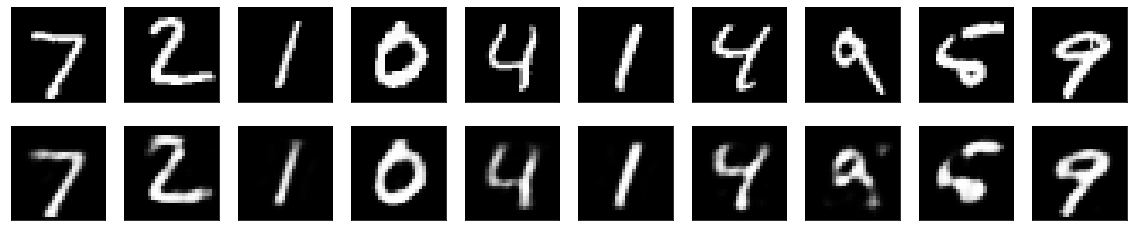

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
